<center>
<b>EC4.403: Robotics: Planning and Navigation</b> <br>
<b>Spring 2021</b> <br>
<b>Assignment-1 </b>
</center>

<div style="text-align: right"><b>Team:</b> Makkhi-2 (2018102023, 2018111003)</div>

# Import libraries

In [1]:
import numpy as np
import cv2
#from google.colab.patches import cv2_imshow
import matplotlib.pyplot as plt
from scipy.spatial import distance
import random

# Create Obstacle World


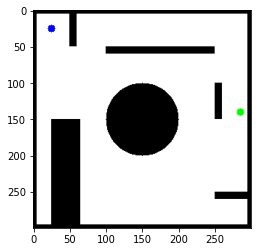

An image of our world.
Blue dot represents start node,
Green dot represents goal node,
Black regions represent obstacles
White regions represent empty spaces



In [2]:
def addRectangle(image,x0,y0,height,width):
    '''Function to add rectangular obstacles to our world. Note that (0,0) corresponds to the top left corner
    of the image'''
    image[y0:y0+height,x0:x0+width,:]=0
    return image

def addCircle(image,center_x, center_y,radius,colour=(0,0,0),thickness=-1):
    '''Function to add circular obstacles to our world. Note that (0,0) corresponds to the top left corner
    of the image'''
    return cv2.circle(image,(center_x,center_y),radius,colour,thickness)

def addBorders(world,border_thickness=5):
    world[:,:border_thickness,:]=0 # Left border
    world[:border_thickness,:,:]=0 # Top border
    world[:,-border_thickness:,:]=0 # Right border
    world[-border_thickness:,:,:]=0 # Bottom border
    return world

def createWorld(height,width,robot_initial_point,robot_final_point):
    '''Function to make the world/occupancy grid.'''
    # Create an empty space of size heightxwidth
    world=np.uint8(np.full((height,width,3),255))
    
    # Add borders to our empty space
    world=addBorders(world)

    # Add rectangular obstacles to the world
    world=addRectangle(world,x0=25,y0=150,height=150,width=40)
    world=addRectangle(world,x0=250,y0=100,height=50,width=10)
    world=addRectangle(world,x0=250,y0=250,height=10,width=50)
    world=addRectangle(world,x0=100,y0=50,height=10,width=150)
    world=addRectangle(world,x0=50,y0=0,height=50,width=10)
    
    # Add circular obstacles to the world    
    world=addCircle(center_x=150,center_y=150,radius=50,image=world)
    
    # Mark start and end points on the world
    world=addCircle(image=world,center_x=robot_initial_point[0],center_y=robot_initial_point[1],\
                    radius=5,colour=(0,0,255),thickness=-1) #Draw a blue circle representing start
    world=addCircle(image=world,center_x=robot_final_point[0],center_y=robot_final_point[1],\
                    radius=5,colour=(0,255,0),thickness=-1) #Draw a green circle representing goal

    '''The empty spaces in the world correspond to the points where world[i][j]=255 and obstacles correspond to 
    places where world[i][j]=0'''    
    
    return world

robot_initial_point=(25,25)
robot_final_point=(285,140)
img_obstacles=createWorld(300,300,robot_initial_point,robot_final_point)

plt.imshow(img_obstacles) # Visualize how are world looks like
plt.show()
print("An image of our world.\nBlue dot represents start node,\nGreen dot represents goal node,\n\
Black regions represent obstacles\nWhite regions represent empty spaces\n")

np_obs_points = np.array(np.where((img_obstacles == [0, 0, 0]).all(axis = 2))) # obstacle pixels indices present in the image
np_obs_points = np_obs_points.T
np_white_points = np.array(np.where((img_obstacles == [255, 255, 255]).all(axis = 2))) # white pixels indices present in the image
np_white_points = np_white_points.T
#cv2_imshow(img_obstacles)

In [3]:
#Robot Chareteristics
b = random.randint(8, 14) # tri-cycle length
d = 5
angle = random.randint(20,30)
max_steer_angle = angle*np.pi/180 # in radians
v_f = 2

robot_initial_point = (55, 30, 0) # row, col, theta
robot_final_point = (140,275) # row, col

# Robot initialization

In [4]:
img_obstacles_mid = img_obstacles[:]

# Tree node

In [5]:
np_rrt_nodes = np.array([*robot_initial_point, 0, 0]).reshape(1, -1) # current_node_r, current_node_c, current_node_theta, parent_steer_angle, parent_index
#np_rrt_nodes.shape

# RRT

In [6]:
def compute_motion_primitive(np_path, steer_angle):
    step_size = 10
    i = 0;
    x_comp = np.sin(steer_angle)
    y_comp = np.cos(steer_angle)
    omega, linear_velo = v_f * x_comp / b, v_f * y_comp
    np_path = np_path.copy()
    np_path = np_path.reshape(1, -1)
    theta_back = np_path[0, 2] - np.pi
    
    y_comp = np.sin(theta_back)
    x_comp =  np.cos(theta_back)
    back_coord = np.array([b * y_comp, b * x_comp]) + np_path[0, :2]
    theta_wheel_1, theta_wheel_2 = np_path[0, 2] - np.pi/2, np_path[0, 2] + np.pi/2
    
    y_comp_1 = np.sin(theta_wheel_1)
    y_comp_2 = np.sin(theta_wheel_2)
    x_comp_1 = np.cos(theta_wheel_1)
    x_comp_2 = np.cos(theta_wheel_2)
    wheel_1_coord = np.array([d * y_comp_1, d * x_comp_1]) + back_coord
    wheel_2_coord = np.array([d * y_comp_2, d * x_comp_2]) + back_coord
    
    np_path_wheel_1 = np.array([*wheel_1_coord, theta_wheel_1])
    np_path_wheel_1 = np_path_wheel_1.reshape(1, -1)
    np_path_wheel_2 = np.array([*wheel_2_coord, theta_wheel_2]).reshape(1, -1)
    np_path_wheel_2 = np_path_wheel_2.reshape(1, -1)
    
    while ( 1 ):
        if (i < step_size):
            y_comp = np.sin(np_path[i, 2])
            x_comp = np.cos(np_path[i, 2])
            temp1 = np_path[i, 0] + linear_velo * y_comp
            temp2 = np_path[i, 1] + linear_velo * x_comp
            temp3 = np_path[i, 2] + omega
            np_path = np.append(np_path, np.array([[temp1, temp2, temp3]]), axis = 0)
            theta_back = np_path[-1, 2] - np.pi
            y_comp = np.sin(theta_back)
            x_comp = np.cos(theta_back)
            back_coord = np.array([b * y_comp, b * x_comp]) + np_path[-1, :2]
            
            theta_wheel_1, theta_wheel_2 = np_path[-1, 2] - np.pi/2, np_path[-1, 2] + np.pi/2
            y_comp_1 = np.sin(theta_wheel_1)
            y_comp_2 = np.sin(theta_wheel_2)
            x_comp_1 = np.cos(theta_wheel_1)
            x_comp_2 = np.cos(theta_wheel_2)
            wheel_1_coord = np.array([d * y_comp_1, d * x_comp_1]) + back_coord
            wheel_2_coord = np.array([d * y_comp_2, d * x_comp_2]) + back_coord
            
            wt_1 = np.array([[*wheel_1_coord, theta_wheel_1]])
            wt_2 = np.array([[*wheel_2_coord, theta_wheel_2]])
            np_path_wheel_1 = np.append(np_path_wheel_1, wt_1, axis = 0)
            np_path_wheel_2 = np.append(np_path_wheel_2, wt_2, axis = 0)
            
            i = i +1;
        else:
            break
    return np_path, np_path_wheel_1, np_path_wheel_2

In [7]:
while True:
    # fetching the random point in configuration space
    start_rand = 0
    end_rand = len(np_white_points)
    random_index = np.random.randint(start_rand, end_rand)
    np_q_rand = np_white_points[random_index] # row, col

    # finding the points with correct steering angle
    # find the vector between two points -> np_q_rand - np_rrt_nodes[:, :2]
    np_temp = np.arctan2((np_q_rand - np_rrt_nodes[:, :2])[:, 0], (np_q_rand - np_rrt_nodes[:, :2])[:, 1]) # find the angle between them
    np_temp = np.logical_and(np_temp <= max_steer_angle, -max_steer_angle <= np_temp)# find the indices of all the points that satify the steering angle condition
    np_temp = np.where(np_temp) 
    if len(np_temp[0]) == 0:
        continue
    else:
        # find the nearest node in the RRT tree
        np_temp = np_rrt_nodes[np_temp[0], :] # find the points in the rrt nodes that satify the steering angle condition
        min_dist = distance.cdist([np_q_rand], np_temp[:, :2])# find the minimum distance among the points satisfying the steering wheel condition
        min_dist = min_dist.argmin()
        np_q_near = np_temp[min_dist] 
        parent_index = np.where((np_rrt_nodes == np_q_near).all(axis = 1))[0][0]
        
        # compute the motion primitive
        steer_angle = np.arctan2((np_q_rand - np_q_near[:2])[0], (np_q_rand - np_q_near[:2])[1]) # in radians
        path_temp = np_q_near[:3]
        np_path, np_path_wheel_1, np_path_wheel_2 = compute_motion_primitive(path_temp, steer_angle)
        np_path[:, :2] = np.round(np_path[:, :2])
        w1 = np_path_wheel_1[:, :2]
        w2 = np_path_wheel_2[:, :2]
        np_path_wheel_1[:, :2] = np.round(w1)
        np_path_wheel_2[:, :2] = np.round(w2)

      # check for the validity of the path
        if (distance.cdist(np_path[:, :2], np_obs_points).min() == 0): 
            continue
        elif (distance.cdist(np_path_wheel_1[:, :2], np_obs_points).min() == 0):
            continue
        elif (distance.cdist(np_path_wheel_2[:, :2], np_obs_points).min() == 0) :
            continue
        else:
        # no collision
            path1 = np_path[-1, 0]
            path2 = np_path[-1, 1]
            path3 = np_path[-1, 2]
            np_rrt_nodes = np.append(np_rrt_nodes, np.array([path1, path2, path3, steer_angle, parent_index]).reshape(1, -1), axis = 0)
        
        for i in range(len(np_path)-1):
            temp1 = tuple(np_path[i, :2].astype(np.int))[::-1]
            temp2 = tuple(np_path[i+1, :2].astype(np.int))[::-1]
            img_obstacles_mid = cv2.line(img_obstacles_mid, temp1, temp2, (0, 0, 255), 1)

      #  near the robot_final_point
        tolarence = 10
        diff = robot_final_point - np_path[-1, :2]
        if (np.linalg.norm(diff) <= tolarence): 
            break

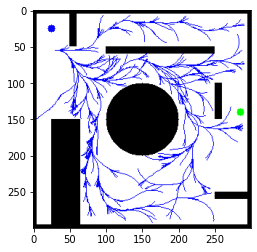

In [8]:
plt.imshow(img_obstacles_mid)

# Trace the path

In [9]:
nodes_indices_to_travel = []
node_index = len(np_rrt_nodes) - 1
while 1:
    if (node_index != 0 ):
        nodes_indices_to_travel.append(node_index)
        node_index = int(np_rrt_nodes[node_index, 4])
    else:
        break
nodes_indices_to_travel.append(node_index)
nodes_indices_to_travel.reverse()

# Show the traced path (mid platform on RRT)

Path traversed graphed


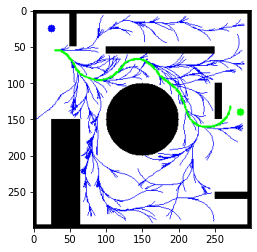

In [10]:
img_obstacles_copy = img_obstacles_mid[:]
#num = 1
for n in range(len(nodes_indices_to_travel)-1):
    w1 = np_rrt_nodes[nodes_indices_to_travel[n], :3]
    w2 = np_rrt_nodes[nodes_indices_to_travel[n+1], 3]
    np_path, np_path_wheel_1, np_path_wheel_2 = compute_motion_primitive(w1, w2)
    for i in range(len(np_path)-1):
        temp1 = tuple(np_path[i, :2].astype(np.int))[::-1]
        temp2 = tuple(np_path[i+1, :2].astype(np.int))[::-1]
        img_obstacles_copy = cv2.line(img_obstacles_copy, temp1, temp2, (0, 255, 0), 2)
    #plt.imshow(img_obstacles_copy)
    #plt.show()
    #img_str = "./nh_reel/" + str(num) + ".png"
    #cv2.imwrite(img_str,img_obstacles_copy)
    #num = num + 1
    
print ("Path traversed graphed")
plt.imshow(img_obstacles_copy)

Path traversed graphed


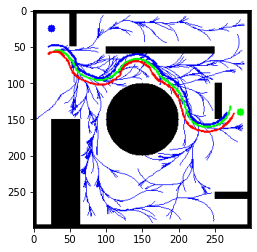

In [11]:
img_obstacles_3 = img_obstacles[:]
for n in range(len(nodes_indices_to_travel)-1):
    w1 = np_rrt_nodes[nodes_indices_to_travel[n], :3]
    w2 = np_rrt_nodes[nodes_indices_to_travel[n+1], 3]
    np_path, np_path_wheel_1, np_path_wheel_2 = compute_motion_primitive(w1, w2)
    for i in range(len(np_path)-1):
        temp1 = tuple(np_path[i, :2].astype(np.int))[::-1]
        temp2 = tuple(np_path[i+1, :2].astype(np.int))[::-1]
        img_obstacles_3 = cv2.line(img_obstacles_3, temp1, temp2, (0, 255, 0), 2)
        temp1 = tuple(np_path_wheel_1[i, :2].astype(np.int))[::-1]
        temp2 = tuple(np_path_wheel_1[i+1, :2].astype(np.int))[::-1]
        img_obstacles_3 = cv2.line(img_obstacles_3, temp1, temp2, (0, 0, 255), 2)
        temp1 = tuple(np_path_wheel_2[i, :2].astype(np.int))[::-1]
        temp2 = tuple(np_path_wheel_2[i+1, :2].astype(np.int))[::-1]
        img_obstacles_3 = cv2.line(img_obstacles_3, temp1, temp2, (255, 0, 0), 2)
    #plt.imshow(img_obstacles_copy)
    #plt.show()
    #img_str = "./nh_reel/" + str(num) + ".png"
    #cv2.imwrite(img_str,img_obstacles_copy)
    #num = num + 1
print ("Path traversed graphed")
#plt.figure(0)
plt.imshow(img_obstacles_3)